In [12]:
from langgraph.graph import StateGraph, MessagesState, END, START
from typing import TypedDict, List
from langchain_core.messages import HumanMessage, AIMessage
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode
from openai import OpenAI
import os
from pydantic import BaseModel, model_validator
from langgraph.graph import MessagesState  
import json



In [19]:
from dotenv import load_dotenv
import os

# Use the current working directory as the base directory
base_dir = os.getcwd()

# If your .env is one level up from the current directory, use this:
dotenv_path = os.path.join(base_dir, '../.env')

# Load environment variables from the .env file
load_dotenv(dotenv_path)

# Get the API key from the environment variables
api_key = os.getenv('OPENAI_API_KEY')

if api_key is None:
    raise ValueError("Environment variable 'OPENAI_API_KEY' is not set. Please check your .env file.")
else:
    print(f"API Key: {api_key[:5]}...{api_key[-5:]}")

client = OpenAI(api_key=api_key)

API Key: sk-79...zHtMA


In [20]:
try:
    models = client.models.list()
    print(f"Available models: {[model.id for model in models.data[:5]]}")
except Exception as e:
    print(f"Error: {str(e)}")

Available models: ['gpt-4o-realtime-preview-2024-10-01', 'chatgpt-4o-latest', 'dall-e-2', 'tts-1', 'tts-1-1106']


In [21]:
# System prompt for consistency across nodes
system_prompt = (
    "You are an AI legal assistant specializing in contract creation and personal information extraction. "
    "Your role is to ensure all responses are formatted clearly, focusing on accuracy, privacy, and legality. "
    "Always ask clarifying questions if any information is incomplete or unclear. Respond concisely and use formal language appropriate for legal contexts."
    "Include all relevant details explicitly and structure output for easy readability."
)


In [22]:
# Define the state with messages and any additional keys
class ContractState(MessagesState):
    pii_data: dict
    address: str
    buyer: str
    seller: str
    contract: str

# Pydantic models for structured validation
class PiiDataModel(BaseModel):
    name: str
    address: str

    @field_validator("name", "address")
    def validate_fields(cls, value):
        if not value:
            raise ValueError("Field cannot be empty")
        return value

class ContractPartiesModel(BaseModel):
    buyer: str
    seller: str

    @field_validator("buyer", "seller")
    def validate_names(cls, value):
        if not value.isalpha():
            raise ValueError("Name must contain only alphabetic characters")
        return value



In [26]:
async def extract_pii_and_address(state: ContractState) -> ContractState:
    documents = get_documents()
    
    if not documents:
        state.messages.append(AIMessage(content="No documents found in the data folder."))
        return state

    async def process_document(doc):
        try:
            with open(doc, 'rb') as file:
                file_content = file.read()

            response = await client.chat.completions.acreate(
                model="chatgpt-4o-latest",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": "Please extract the full name and address from the provided document."},
                    {
                        "role": "user",
                        "content": [
                            {"type": "image", "image_bytes": file_content},
                        ],
                    },
                ],
                max_tokens=300,
            )

            extracted_text = response.choices[0].message.content

            # Process extracted text to identify PII using function calling
            pii_response = await client.chat.completions.acreate(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": extracted_text}
                ],
                functions=[{
                    "name": "extract_pii_data",
                    "description": "Extracts the person's full name and address from the provided text.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "name": {"type": "string", "description": "Full name of the person."},
                            "address": {"type": "string", "description": "Residential address of the person."}
                        },
                        "required": ["name", "address"]
                    }
                }],
                function_call={"name": "extract_pii_data"}
            )

            pii_data = json.loads(pii_response.choices[0].message.function_call.arguments)
            
            # Validate and update state
            pii_data_model = PiiDataModel(**pii_data)
            state.pii_data = pii_data_model.dict()
            state.address = pii_data_model.address
            state.messages.append(AIMessage(content=f"Extracted PII from {doc}: {pii_data}"))
            return True
        except json.JSONDecodeError:
            state.messages.append(AIMessage(content=f"Error decoding JSON response for {doc}"))
        except ValueError as e:
            state.messages.append(AIMessage(content=f"Validation error for {doc}: {str(e)}"))
        except Exception as e:
            state.messages.append(AIMessage(content=f"Unexpected error processing {doc}: {str(e)}"))
        return False

    tasks = [process_document(doc) for doc in documents]
    results = await asyncio.gather(*tasks)

    if not any(results):
        state.messages.append(AIMessage(content="Failed to extract PII from any document."))

    return state

async def human_verification(state: ContractState) -> ContractState:
    verification_prompt = f"Is this information correct?\nName: {state['pii_data']['name']}, Address: {state['address']}"
    response = await client.ChatCompletion.acreate(
        model="chatgpt-4o-latest",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": verification_prompt}
        ],
        max_tokens=50,
        temperature=0.7
    )
    state["messages"].append({"role": "human", "content": response.choices[0].text.strip()})
    return state

# Update the rest of the functions to be async
def missing_information(state: ContractState) -> ContractState:
    state["messages"].append({"role": "human", "content": "Please provide the missing information regarding PII or address."})
    return state

async def identify_buyer_and_seller(state: ContractState) -> ContractState:
    # Using function calling to extract buyer and seller details
    functions = [
        {
            "name": "identify_parties",
            "description": "Identifies the buyer and seller from the given text.",
            "parameters": {
                "type": "object",
                "properties": {
                    "buyer": {"type": "string", "description": "Name of the buyer."},
                    "seller": {"type": "string", "description": "Name of the seller."}
                },
                "required": ["buyer", "seller"]
            }
        }
    ]

    response = await client.ChatCompletion.acreate(
        model="chatgpt-4o-latest",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": "Identify the buyer and seller from the context."}
        ],
        functions=functions,
        function_call="auto"
    )
    parties = response.choices[0].message['function_call']['arguments']
    # Validate using Pydantic
    parties_model = ContractPartiesModel(**parties)
    state.buyer = parties_model.buyer
    state.seller = parties_model.seller
    return state

async def construct_contract(state: ContractState) -> ContractState:
    # Using function calling to generate the contract
    functions = [
        {
            "name": "generate_contract",
            "description": "Generates a contract between buyer and seller for the given address.",
            "parameters": {
                "type": "object",
                "properties": {
                    "buyer": {"type": "string", "description": "Name of the buyer."},
                    "seller": {"type": "string", "description": "Name of the seller."},
                    "address": {"type": "string", "description": "Address where the contract is applicable."}
                },
                "required": ["buyer", "seller", "address"]
            }
        }
    ]

    response = await client.ChatCompletion.acreate(
        model="chatgpt-4o-latest",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": "Create a contract between buyer and seller."}
        ],
        functions=functions,
        function_call="auto"
    )
    contract = response.choices[0].message['function_call']['arguments']
    state.contract = contract
    return state

In [32]:
import asyncio

async def main():

    # Create the graph
    graph = StateGraph(ContractState)

    # Add nodes
    graph.add_node("extract_pii_and_address", extract_pii_and_address)
    graph.add_node("human_verification", human_verification)
    graph.add_node("missing_information", missing_information)
    graph.add_node("identify_buyer_and_seller", identify_buyer_and_seller)
    graph.add_node("construct_contract", construct_contract)

    # Define edges
    graph.set_entry_point("extract_pii_and_address")
    graph.add_edge("extract_pii_and_address", "human_verification")
    graph.add_conditional_edges("human_verification", lambda state: "missing_information" if "missing" in state else "identify_buyer_and_seller")
    graph.add_edge("missing_information", "human_verification")
    graph.add_edge("identify_buyer_and_seller", "construct_contract")
    graph.add_edge("construct_contract", END)

    # Compile the graph
    app = graph.compile()

    # Example invocation
    initial_state = {"messages": []}
    result = await app.ainvoke(initial_state)
    print(result)

asyncio.run(main())




RuntimeError: asyncio.run() cannot be called from a running event loop

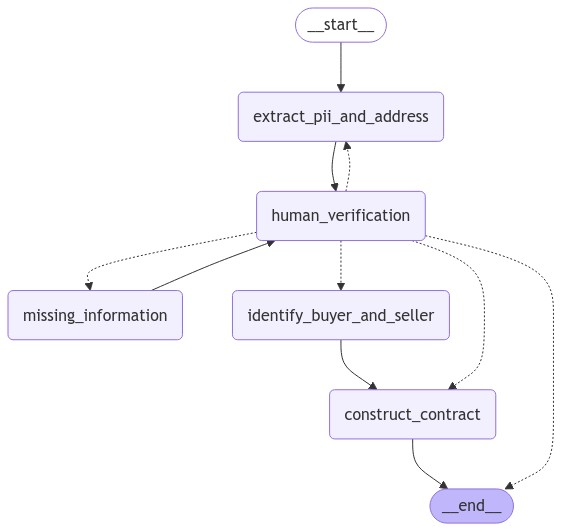

In [5]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass